In [121]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt

In [123]:
import numpy as np
from numpy import concatenate

In [124]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [125]:
%store -r ili_GLL

In [126]:
l = len(ili_GLL.columns)
print("The data contains {} features".format(l))
ili_GLL.head()

The data contains 8 features


,date,year,month,week,state,latitude,longitude,ili_activity_group
0,2010-10-09,2010,10,40,AK,61.370716,-152.404419,Minimal
1,2010-10-16,2010,10,41,AK,61.370716,-152.404419,Minimal
2,2010-10-23,2010,10,42,AK,61.370716,-152.404419,Minimal
3,2010-10-30,2010,10,43,AK,61.370716,-152.404419,Minimal
4,2010-11-06,2010,10,44,AK,61.370716,-152.404419,Minimal


In [127]:
#we put everything together
#sepate by states
datasets = {}
states_label = ili_GLL.state.unique()

In [128]:
for s in states_label:
    datasets[s] = ili_GLL[(ili_GLL.state == s)]
    datasets[s].drop(['date'], 1, inplace=True)
    datasets[s].drop(['state'], 1, inplace=True)

/Users/bbuildman/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/bbuildman/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [129]:
nstates = len(datasets)
print("Number of location : {}".format(nstates))

Number of location : 46


In [130]:
datasets.pop('AL', None)
print(datasets.keys())

['WA', 'DE', 'WI', 'WV', 'HI', 'WY', 'NH', 'NM', 'TX', 'NC', 'ND', 'NE', 'TN', 'NY', 'PA', 'CA', 'NV', 'VA', 'CO', 'AK', 'AR', 'VT', 'IL', 'GA', 'IN', 'IA', 'OK', 'AZ', 'ID', 'CT', 'ME', 'MD', 'MA', 'OH', 'UT', 'MO', 'MN', 'MI', 'KS', 'MT', 'MS', 'SC', 'KY', 'OR', 'SD']


In [131]:
# load dataset
dataset = datasets['NC']
dataset.head()

,year,month,week,latitude,longitude,ili_activity_group
6254,2010,10,41,35.630066,-79.806419,Minimal
6255,2010,10,42,35.630066,-79.806419,Minimal
6256,2010,10,43,35.630066,-79.806419,Minimal
6257,2010,10,44,35.630066,-79.806419,Minimal
6258,2010,11,44,35.630066,-79.806419,Minimal


In [132]:
values = dataset.values

In [133]:
# integer encode direction
encoder = LabelEncoder()
values[:,5] = encoder.fit_transform(values[:,5])
# ensure all data is float
values = values.astype('float32')

In [134]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var6(t)
1        0.0   0.818182   0.769231        0.0        0.0   0.666667  0.666667
2        0.0   0.818182   0.788462        0.0        0.0   0.666667  0.666667
3        0.0   0.818182   0.807692        0.0        0.0   0.666667  0.666667
4        0.0   0.818182   0.826923        0.0        0.0   0.666667  0.666667
5        0.0   0.909091   0.826923        0.0        0.0   0.666667  0.666667


In [135]:
# split into train and test sets
values = reframed.values
n_train_weeks = 52 * 3
train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((156, 1, 6), (156,), (40, 1, 6), (40,))


In [136]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [137]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 156 samples, validate on 40 samples
Epoch 1/50
 - 2s - loss: 0.4205 - acc: 0.0962 - val_loss: 0.4400 - val_acc: 0.1250
Epoch 2/50
 - 0s - loss: 0.3908 - acc: 0.0962 - val_loss: 0.4084 - val_acc: 0.1250
Epoch 3/50
 - 0s - loss: 0.3617 - acc: 0.0962 - val_loss: 0.3776 - val_acc: 0.1250
Epoch 4/50
 - 0s - loss: 0.3335 - acc: 0.0962 - val_loss: 0.3482 - val_acc: 0.1250
Epoch 5/50
 - 0s - loss: 0.3067 - acc: 0.0962 - val_loss: 0.3202 - val_acc: 0.1250
Epoch 6/50
 - 0s - loss: 0.2811 - acc: 0.0962 - val_loss: 0.2936 - val_acc: 0.1250
Epoch 7/50
 - 0s - loss: 0.2569 - acc: 0.0962 - val_loss: 0.2684 - val_acc: 0.1250
Epoch 8/50
 - 0s - loss: 0.2340 - acc: 0.0962 - val_loss: 0.2448 - val_acc: 0.1250
Epoch 9/50
 - 0s - loss: 0.2126 - acc: 0.0962 - val_loss: 0.2227 - val_acc: 0.1250
Epoch 10/50
 - 0s - loss: 0.1926 - acc: 0.0962 - val_loss: 0.2021 - val_acc: 0.1250
Epoch 11/50
 - 0s - loss: 0.1740 - acc: 0.0962 - val_loss: 0.1832 - val_acc: 0.1250
Epoch 12/50
 - 0s - loss: 0.1569 - acc: 

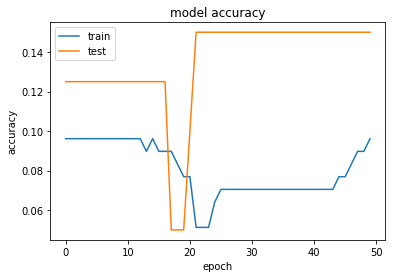

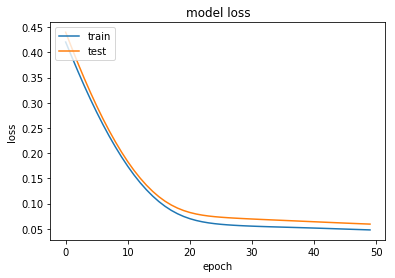

In [138]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [139]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [140]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.218


In [142]:
def create_model(labels, refraimed_data, batch_size = 52, n_neurons = 50):
    #dataLength =  4 weeks
    stateInputs = {}
    stateLayers = []
    i = 0
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    for label in labels:
        data = refraimed_data[i]
        i+=1
        timesteps = data.shape[1]
        features = data.shape[2]
        print("timesteps: {}".format(timesteps))
        inputName = "{}_input".format(label)
        stateInputs[inputName] = Input(shape=(timesteps,features),
                                       batch_shape =(batch_size, timesteps, features), 
                                       name=inputName)
        
    for state in stateInputs:
        stateL = LSTM(n_neurons, return_sequences=False, stateful=True,
                            batch_input_shape=(batch_size, timesteps, features))(stateInputs[state])
        stateLayers.append(stateL)
    #combined the output
    output = keras.layers.concatenate(stateLayers)
    output = Dense(1, activation='relu', name='wheighthedAverage_output')(output)
    stateInput = stateInputs.values()
    
    model = Model(inputs = stateInput, outputs = [output])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model